In [1]:
from ctmnet2.simulation import Simulator

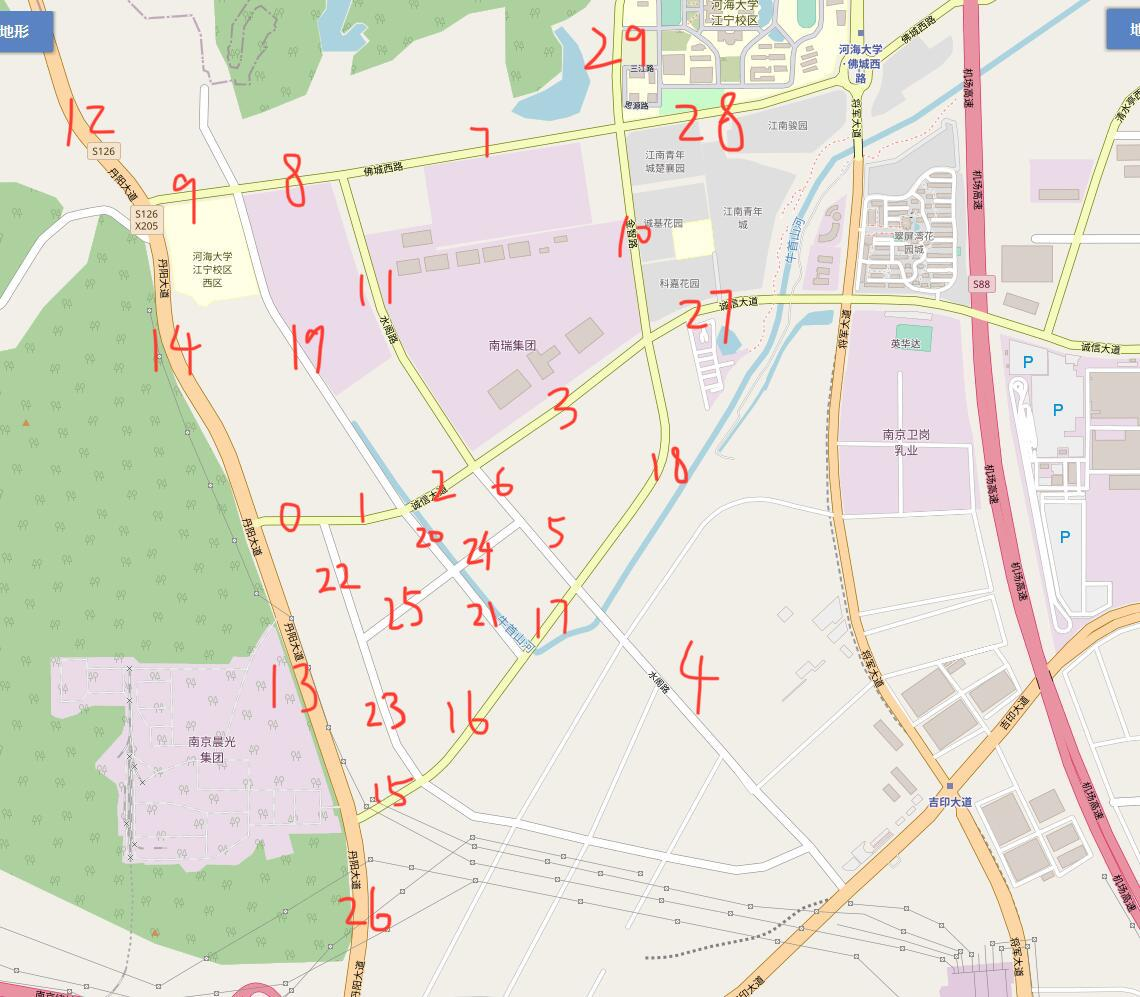

In [1]:
from IPython.display import Image
Image("NET.jpg")

## 设置输入输出的路段

In [22]:
U=[12,56,34,57,58,59]
D=[42,26,4,27,28,29]

## 建立路网、建立默认的信号灯、设置到达离去

In [23]:
from ctmnet2.networkcreation import create_from_xml

sim = create_from_xml("net1++.xml")

for sec_id in sim.sections.keys():
    sim.create('SignalController',sec_id,{'cycle': 60})
    sim.create('Phase',sec_id,{'green_start': 20,'green_end': 59})
    sim.add_lamp(sec_id,sec_id,sec_id)
for u in U:
    sim.set_arrival(str(u),1750*2)
for d in D:
    sim.set_departure(str(d),1750)

## 开始仿真并输出结果

In [24]:
%%time

import numpy as np

result = []
r = []
for i in range(1800):
    r = []
    sim.run_single_step()
    V = sim.get_volume('cell')
    #S = sim.get_volume('section')
    '''if i<720 and i>690 and i%3==0:
        print(V['9'])
        print(V['10'])
        print(V['11'])'''
    if i>1500:
        for d in D:
            sim.set_departure(str(d),900)
    if i>1650:
        for d in D:
            sim.set_departure(str(d),1750*2)
    if i>1500 and i<1800:
        for j in range(30):
            t=[]
            for k in range(len(V[str(j)])):
                t.append(V[str(j)][k]+V[str(j+30)][len(V[str(j)])-k-1])
            r=r+[round(i,1) for i in t]
        result.append(r)
#print(result)

Wall time: 13.1 s


section的流量是保留到个位，有些section的数据就一直为零，但实际上是连上的。

查看每一个路段上的元胞数量

In [25]:
import numpy as np

sim.run_single_step()
V = sim.get_volume('cell')
n = 0
for j in range(30):
    n = n+len(V[str(j)])
    print(j,len(V[str(j)]),n)
    #t=np.array(V[str(j)])+np.array(V[str(j+30)])
    #print(t)

0 6 6
1 7 13
2 7 20
3 18 38
4 29 67
5 7 74
6 6 80
7 23 103
8 9 112
9 8 120
10 18 138
11 26 164
12 19 183
13 26 209
14 28 237
15 7 244
16 13 257
17 8 265
18 22 287
19 30 317
20 7 324
21 10 334
22 11 345
23 13 358
24 7 365
25 10 375
26 16 391
27 5 396
28 14 410
29 7 417


转置并查看元胞总数和时长

In [26]:
T = []
for i in range(len(result[0])):  # 行数
    t = []
    for j in range(len(result)):
        t.append(result[j][i])
    T.append(t)
#print(T)
print(len(T),len(T[0]))

417 299


仿真结果写入文本

In [27]:
with open('4Netdata+++.txt','a') as file_handle:
    for t in T:
        file_handle.write(str(t)+',\n')

计算路网中各路段元胞间坐标的平均值

In [2]:
import xml.etree.ElementTree as ET
import re

tree = ET.parse("net1++.xml")
root = tree.getroot()
para = 'coordinates'
coordinates=[]
for sec in root.iter('section'):
    sec_id = sec.attrib['id']
    coors = re.findall(r"(\d+\.?\d*, \d+\.?\d*)",sec.find(para).text)
    COORS = []
    COOR = []
    COORDINATE = [0,0]
    COORDINATES = []
    for coor in coors:
        COOR = coor.split(',')
        COOR[0]=float(COOR[0])
        COOR[1]=float(COOR[1])
        COORS.append(COOR)
    #print(len(COORS))
    #print(COORS[6])
    for i in range(len(COORS)-1):
        COORDINATE[0] = (COORS[i][0]+COORS[i+1][0])/2
        COORDINATE[1] = (COORS[i][1]+COORS[i+1][1])/2
        COORDINATES.append(COORDINATE.copy())
    #print(COORDINATES)
    coordinates.extend(COORDINATES)
    #print(sec_id,len(COORDINATES))

In [115]:
#print(len(coordinates))
print(coordinates)

[[31.897945392496197, 118.76063204667926], [31.897965977488596, 118.76116054003782], [31.897986562480988, 118.76168903339638], [31.898007147473386, 118.76221752675492], [31.898027732465778, 118.76274602011347], [31.89804326248099, 118.76314473339637], [31.898075162610166, 118.7635418544283], [31.898128487830494, 118.76406716328488], [31.898181813050822, 118.76459247214146], [31.898235138271147, 118.76511778099805], [31.898288463491475, 118.76564308985465], [31.898341788711804, 118.76616839871122], [31.898384025660985, 118.76658447656976], [31.898519152576128, 118.766961830943], [31.898758257728375, 118.76740969282903], [31.89899736288063, 118.76785755471505], [31.899236468032882, 118.76830541660107], [31.89947557318513, 118.7687532784871], [31.899714678337382, 118.76920114037313], [31.899922115456754, 118.76958968565808], [31.90014283371343, 118.7699676016109], [31.900408501140298, 118.7703942048327], [31.900674168567157, 118.7708208080545], [31.90093983599402, 118.77124741127629], [31

In [118]:
with open('Coordata.txt','a') as file_handle:
    for coor in coordinates:
        file_handle.write('{"lat":'+str(coor[0])+',"lng":'+str(coor[1])+'},\n')

## 区域内道路总长

In [4]:
import xml.etree.ElementTree as ET
import re

tree = ET.parse("net1++.xml")
root = tree.getroot()
para = 'lanes_length'
S = 0
for sec in root.iter('section'):
    S += float(sec.find(para).text)
print(round(S,2))

40322.46
